# 1H Strategy Tester

Notebook untuk menguji strategi trading 1 jam (1H). Isi path data OHLCV, pilih strategi, lalu jalankan sel untuk menghitung metrik performa, statistik trade, dan visualisasi ekuitas.

In [1]:
from __future__ import annotations

import contextlib
import sys
from pathlib import Path


def locate_project_root() -> tuple[Path, Path]:
    current = Path.cwd().resolve()
    for candidate in (current, *current.parents):
        src_dir = candidate / "src"
        if src_dir.exists():
            return candidate, src_dir
    raise RuntimeError("Tidak dapat menemukan folder 'src'.")


PROJECT_ROOT, SRC_PATH = locate_project_root()

for path in (PROJECT_ROOT, SRC_PATH):
    path_str = str(path)
    if path_str not in sys.path:
        sys.path.insert(0, path_str)

try:
    import sitecustomize  # noqa: F401
except Exception:
    with contextlib.suppress(Exception):
        import matplotlib

        rc_params = getattr(matplotlib, "rcParams", None)
        if rc_params is not None and not hasattr(rc_params, "_get"):
            rc_params._get = rc_params.get  # type: ignore[attr-defined]

print(f"Project root: {PROJECT_ROOT}")
print(f"SRC path   : {SRC_PATH}")

Project root: C:\Users\jefri\backtest-indicator
SRC path   : C:\Users\jefri\backtest-indicator\src


In [2]:
from dataclasses import asdict
import matplotlib.pyplot as plt
import pandas as pd

from backtest import performance_metrics, run_backtest
from data_loader import load_ohlcv_csv
from properties import StrategyProperties
from qflib_metrics import qflib_metrics_from_returns
from trade_analysis import failed_entries, generate_trade_log, summarise_trades
from strategy_registry import available_strategies, get_strategy


## Konfigurasi Awal

Ubah path CSV dan parameter strategi sesuai kebutuhan Anda. CSV harus berisi kolom `time` berformat UNIX timestamp serta kolom harga standar (`open`, `high`, `low`, `close`).

In [3]:
CSV_PATH = PROJECT_ROOT / "data" / "sample_1h_data.csv"  # Ganti dengan file Anda
STRATEGY_NAME = "ema112"  # Pilih dari available_strategies()
PROPERTIES = StrategyProperties(
    symbol="BTCUSDT",
    timeframe="1H",
    initial_capital=10_000.0,
    trading_cost_bps=0.0,
)

print(f"CSV path      : {CSV_PATH}")
print(f"Strategy name : {STRATEGY_NAME}")
print(f"Initial capital: {PROPERTIES.initial_capital:,.2f}")


CSV path      : C:\Users\jefri\backtest-indicator\data\sample_1h_data.csv
Strategy name : ema112
Initial capital: 10,000.00


In [4]:
if not CSV_PATH.exists():
    raise FileNotFoundError(
        f"File data tidak ditemukan: {CSV_PATH}. Perbarui variabel CSV_PATH sebelum melanjutkan."
    )

raw_data = load_ohlcv_csv(str(CSV_PATH))
raw_data.tail()


,open,high,low,close
time,,,,
2023-01-30 19:00:00+00:00,22455.760115,22464.804426,22453.393249,22450.016391
2023-01-30 20:00:00+00:00,22406.363598,22413.195506,22392.155362,22406.264213
2023-01-30 21:00:00+00:00,22423.887282,22446.697893,22390.473622,22432.290957
2023-01-30 22:00:00+00:00,22361.475546,22373.046736,22307.897981,22381.621570
2023-01-30 23:00:00+00:00,22367.410251,22426.070250,22322.025258,22376.473556


Strategi tersedia: atr_filter, ema112, ema45, ema50, ema_vs_price, macd, oversold


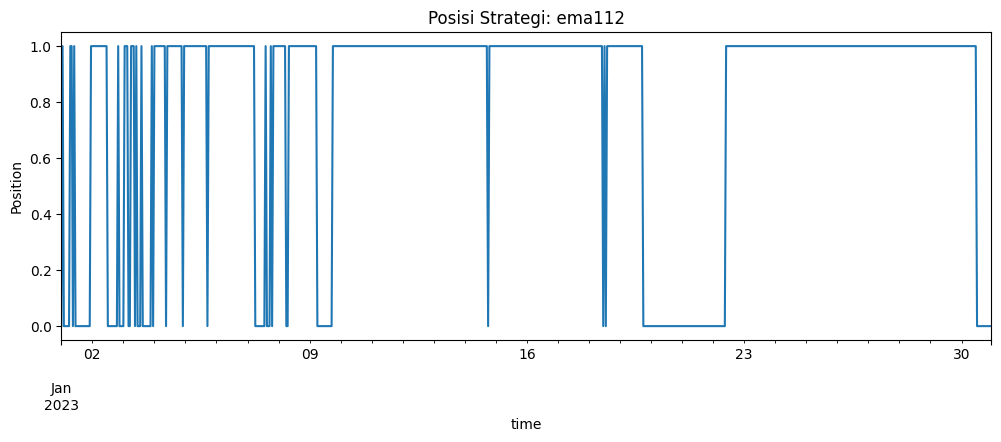

In [5]:
print("Strategi tersedia:", ", ".join(available_strategies()))
strategy_fn = get_strategy(STRATEGY_NAME)
positions = strategy_fn(raw_data)

fig, ax = plt.subplots(figsize=(12, 4))
positions.plot(ax=ax)
ax.set_title(f"Posisi Strategi: {STRATEGY_NAME}")
ax.set_ylabel("Position")
plt.show()


In [6]:
backtest_kwargs = PROPERTIES.to_kwargs()
result = run_backtest(raw_data, positions, **backtest_kwargs)
result[["close", "position", "strategy_ret", "equity_curve"]].head()


,close,position,strategy_ret,equity_curve
time,,,,
2023-01-01 00:00:00+00:00,20034.028145,0.0,0.000000,10000.000000
2023-01-01 01:00:00+00:00,20108.425611,1.0,0.000000,10000.000000
2023-01-01 02:00:00+00:00,19997.957481,0.0,-0.005494,9945.063759
2023-01-01 03:00:00+00:00,19954.852657,0.0,-0.000000,9945.063759
2023-01-01 04:00:00+00:00,19938.669364,0.0,-0.000000,9945.063759


In [7]:
perf_metrics = performance_metrics(result["equity_curve"])
qflib_stats = qflib_metrics_from_returns(result["strategy_ret"])

print("Performance Metrics:")
display(pd.Series(perf_metrics, name="Backtest"))

print("QF-Lib Metrics:")
display(pd.Series(qflib_stats, name="QF-Lib"))


Performance Metrics:


total_return               0.068602
annualized_return          0.023528
annualized_volatility      0.035929
sharpe_ratio               0.654844
max_drawdown              -0.045459
max_drawdown_duration    379.000000
Name: Backtest, dtype: float64

QF-Lib Metrics:


total_return              0.068602
cagr                      0.023495
sharpe_ratio              0.664350
annualised_vol            0.035929
max_drawdown             -0.045459
avg_drawdown_duration    35.315789
Name: QF-Lib, dtype: float64

In [8]:
trade_log = generate_trade_log(result, initial_capital=PROPERTIES.initial_capital)
trade_summary = summarise_trades(trade_log)

print("Ringkasan Trade:")
display(pd.Series(asdict(trade_summary), name="Summary"))

print("Log Trade (5 baris terakhir):")
display(trade_log.tail())


Ringkasan Trade:


total_trades                23.000000
winning_trades               9.000000
losing_trades                5.000000
win_rate                     0.391304
gross_profit              1376.218467
gross_loss                 -79.100572
net_profit                1297.117895
average_return_pct           0.005756
average_trade_duration      24.652174
Name: Summary, dtype: float64

Log Trade (5 baris terakhir):


,entry_time,exit_time,direction,signal,entry_price,exit_price,entry_equity,exit_equity,return_pct,net_pnl,gross_profit,gross_loss,bars_held,max_drawdown,trading_cost_value,position_size,stop_loss,is_win,cumulative_pnl
18,2023-01-09 18:00:00+00:00,2023-01-14 17:00:00+00:00,1.0,Long,20252.567947,20781.966966,9545.406430,9794.921890,0.026140,249.515460,249.515460,0.0,120,-0.018540,0.0,9545.406430,NaN,True,248.792623
19,2023-01-14 19:00:00+00:00,2023-01-18 10:00:00+00:00,1.0,Long,20822.599629,21217.482494,9763.764421,9948.925896,0.018964,185.161475,185.161475,0.0,88,-0.015579,0.0,9763.764421,NaN,True,433.954098
20,2023-01-18 12:00:00+00:00,2023-01-18 12:00:00+00:00,1.0,Long,21188.677223,21188.677223,9917.094245,9917.094245,0.000000,0.000000,0.000000,0.0,1,0.000000,0.0,9917.094245,NaN,False,433.954098
21,2023-01-18 14:00:00+00:00,2023-01-19 17:00:00+00:00,1.0,Long,21210.248545,21292.528919,9902.860113,9941.276025,0.003879,38.415912,38.415912,0.0,28,-0.006766,0.0,9902.860113,NaN,True,472.370010
22,2023-01-22 10:00:00+00:00,2023-01-30 11:00:00+00:00,1.0,Long,20936.331930,22682.123622,9890.753613,10715.501498,0.083386,824.747885,824.747885,0.0,194,-0.022218,0.0,9890.753613,NaN,True,1297.117895


In [9]:
failed_trades = failed_entries(trade_log)
print(f"Total trade gagal/threshold: {len(failed_trades)}")
display(failed_trades.head())


Total trade gagal/threshold: 14


,entry_time,exit_time,direction,signal,entry_price,exit_price,entry_equity,exit_equity,return_pct,net_pnl,gross_profit,gross_loss,bars_held,max_drawdown,trading_cost_value,position_size,stop_loss,is_win,cumulative_pnl,failure_reason
0,2023-01-01 01:00:00+00:00,2023-01-01 01:00:00+00:00,1.0,Long,20108.425611,20108.425611,10000.000000,10000.000000,0.000000,0.000000,0.0,0.000000,1,0.000000,0.0,10000.000000,NaN,False,0.000000,Net P&L equals threshold
2,2023-01-01 10:00:00+00:00,2023-01-01 10:00:00+00:00,1.0,Long,20049.731306,20049.731306,9927.245693,9927.245693,0.000000,0.000000,0.0,0.000000,1,0.000000,0.0,9927.245693,NaN,False,7.120659,Net P&L equals threshold
3,2023-01-01 23:00:00+00:00,2023-01-02 11:00:00+00:00,1.0,Long,20093.435082,20064.645567,9916.415603,9902.207540,-0.001433,-14.208063,0.0,-14.208063,13,-0.009562,0.0,9916.415603,NaN,False,-7.087404,Negative net P&L
4,2023-01-02 20:00:00+00:00,2023-01-02 20:00:00+00:00,1.0,Long,20059.376842,20059.376842,9862.553114,9862.553114,0.000000,0.000000,0.0,0.000000,1,0.000000,0.0,9862.553114,NaN,False,-7.087404,Net P&L equals threshold
5,2023-01-03 01:00:00+00:00,2023-01-03 03:00:00+00:00,1.0,Long,20099.945387,20038.517270,9837.145422,9807.081792,-0.003056,-30.063630,0.0,-30.063630,3,-0.003056,0.0,9837.145422,NaN,False,-37.151034,Negative net P&L


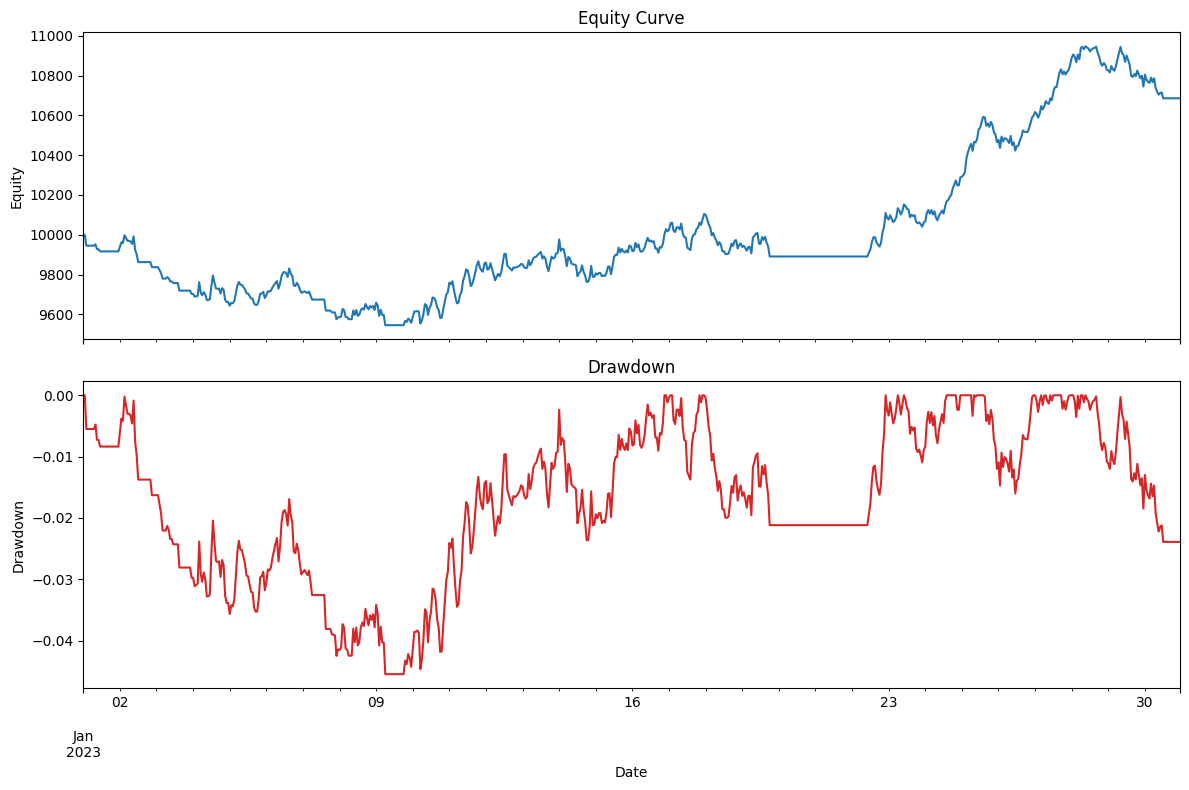

In [10]:
fig, (ax_eq, ax_dd) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
result["equity_curve"].plot(ax=ax_eq, color="tab:blue")
ax_eq.set_title("Equity Curve")
ax_eq.set_ylabel("Equity")

result["drawdown"].plot(ax=ax_dd, color="tab:red")
ax_dd.set_title("Drawdown")
ax_dd.set_ylabel("Drawdown")
ax_dd.set_xlabel("Date")

plt.tight_layout()
plt.show()
